# Running simulations

###  import required modules

In [1]:
import numpy as np
from pydemic import (PopulationModel, AgeDistribution, SeverityModel,
                     EpidemiologyModel, date_to_ms)
from pydemic.models import NeherModelSimulation

In [3]:
start_date = (2020, 2, 23, 0, 0, 0)
end_date = (2020, 11, 1, 0, 0, 0)

# use get_* data methods
population = PopulationModel(
    country='United States of America',
    cases='USA-Illinois',
    population_served=12659682,
    suspected_cases_today=10,  # originally 215
    ICU_beds=1e10,  # originally 1055
    hospital_beds=1e10,  # originally 31649
    imports_per_day=0,  # originally 5.0
)
age_distribution = AgeDistribution(
    bin_edges=np.arange(0, 90, 10),
    counts=[39721484, 42332393, 46094077, 44668271, 40348398, 42120077,
            38488173, 24082598, 13147180]
)
severity = SeverityModel(
    id=np.array([0, 2, 4, 6, 8, 10, 12, 14, 16]),
    age_group=age_distribution.bin_edges,
    isolated=np.array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    confirmed=np.array([5., 5., 10., 15., 20., 25., 30., 40., 50.]),
    severe=np.array([1., 3., 3., 3., 6., 10., 25., 35., 50.]),
    critical=np.array([5., 10., 10., 15., 20., 25., 35., 45., 55.]),
    fatal=np.array([30., 30., 30., 30., 30., 40., 40., 50., 50.]),
)
epidemiology = EpidemiologyModel(
    r0=2.7,
    incubation_time=1,
    infectious_period=5,
    length_hospital_stay=7,
    length_ICU_stay=7,
    seasonal_forcing=0.2,
    peak_month=0,
    overflow_severity=2
)

In [4]:
def sim_from_containment_model(contain):
    # create simulation object
    sim = NeherModelSimulation(
        epidemiology, severity, population.imports_per_day,
        len(age_distribution.counts), contain
    )

    # set initial conditions
    y0 = sim.get_initial_population(population, age_distribution)

    # run deterministic solver
    result = sim.solve_deterministic((start_date, end_date), y0)

    # sample output once per day
    times = np.arange(result.t[0], result.t[-1])
    return sim.dense_to_logger(result, times)

In [64]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['font.family'] = [u'serif']
plt.rcParams['font.size'] = 16

In [74]:
from pydemic import ContainmentModel
results = {}

In [75]:
containment = ContainmentModel(start_date, end_date)
results['no_containment'] = sim_from_containment_model(containment), containment

In [76]:
containment = ContainmentModel(start_date, end_date)
containment.add_sharp_event((2020, 3, 20), factor=.7, dt_days=1)
results['contain .7'] = sim_from_containment_model(containment), containment

In [77]:
containment = ContainmentModel(start_date, end_date)
containment.add_sharp_event((2020, 3, 20), factor=.3, dt_days=1)
results['contain .3'] = sim_from_containment_model(containment), containment

In [78]:
containment = ContainmentModel(start_date, end_date)
containment.add_sharp_event((2020, 3, 20), factor=.3, dt_days=1)
containment.add_sharp_event((2020, 5, 15), factor=1, dt_days=1)
results['contain .3 release 5/15'] = sim_from_containment_model(containment), containment

In [79]:
containment = ContainmentModel(start_date, end_date)
containment.add_sharp_event((2020, 3, 20), factor=.3, dt_days=1)
containment.add_sharp_event((2020, 7, 15), factor=1, dt_days=1)
results['contain .3 release 7/15'] = sim_from_containment_model(containment), containment

In [97]:
containment = ContainmentModel(start_date, end_date)
f1 = .2
f2 = .7
containment.add_sharp_event((2020, 3, 20), factor=f1, dt_days=1)
containment.add_sharp_event((2020, 4, 15), factor=f2, dt_days=1)
containment.add_sharp_event((2020, 5, 15), factor=f1, dt_days=1)
containment.add_sharp_event((2020, 6, 15), factor=f2, dt_days=1)
containment.add_sharp_event((2020, 7, 15), factor=f1, dt_days=1)
containment.add_sharp_event((2020, 8, 15), factor=f2, dt_days=1)
containment.add_sharp_event((2020, 9, 15), factor=f1, dt_days=1)
containment.add_sharp_event((2020, 10, 15), factor=f2, dt_days=1)

results['oscillate .2 .7'] = sim_from_containment_model(containment), containment

In [98]:
# load reported data
from pydemic.load import get_case_data
cases = get_case_data("USA-Illinois")

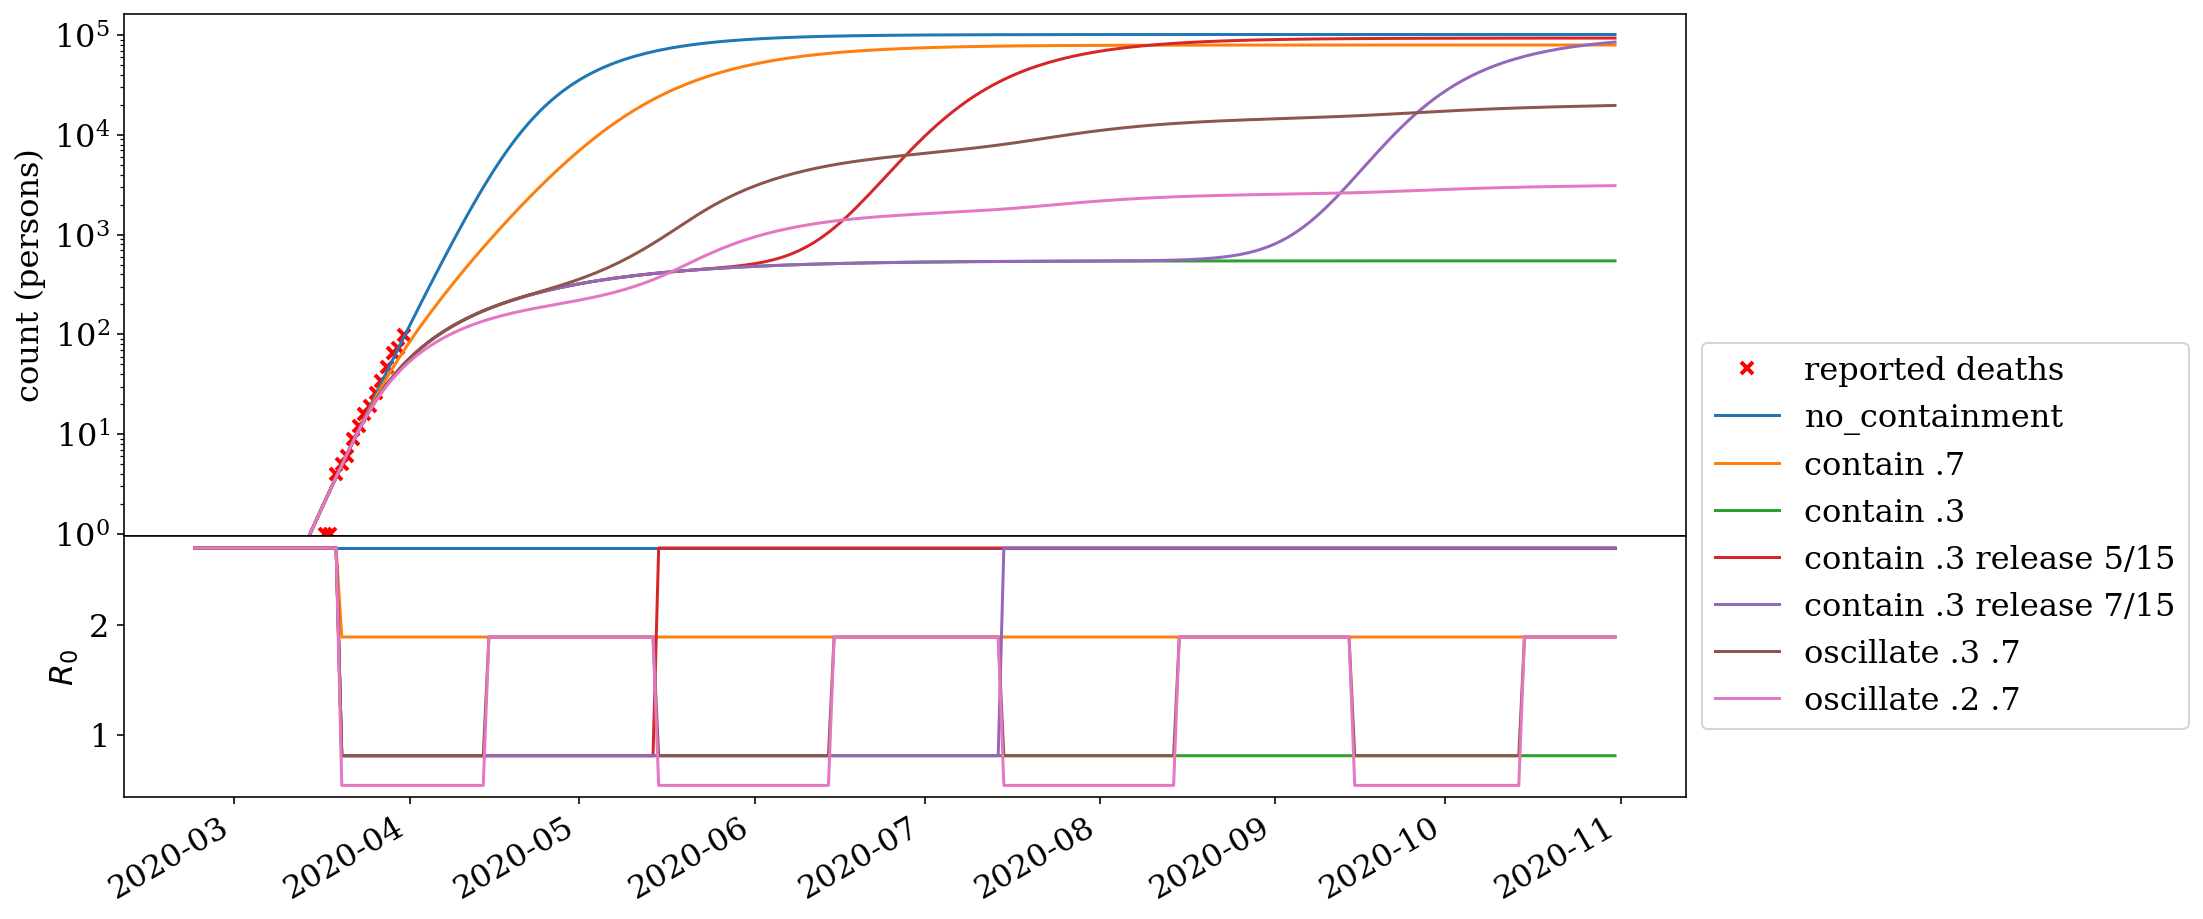

In [105]:
fig = plt.figure(figsize=(14, 8))

import matplotlib.gridspec as gridspec
gspec = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
ax = [fig.add_subplot(gspec[:2,0]), fig.add_subplot(gspec[2,0])]

def days_to_dates(days):
    return [datetime(2020, 1, 1) + timedelta(x) for x in days]

ax[0].semilogy(days_to_dates(cases.dates), cases.deaths,
            'x', c='r', ms=6, markeredgewidth=2,
            label='reported deaths')

for label, (result, contain) in results.items():
    ax[0].semilogy(days_to_dates(result.t), result.y['dead'].sum(axis=-1),
                '-', linewidth=1.5, label=label)
    
    ax[1].plot(days_to_dates(result.t), 2.7 * contain(result.t),
                '-', linewidth=1.5, label=label)

ax[0].set_ylabel("count (persons)")
ax[1].set_ylabel(r'$R_0$')
# ax.set_xlabel("date")
ax[0].set_ylim(.95, .5 * ax[0].get_ylim()[1])
ax[0].legend(bbox_to_anchor=(1, 0), loc='center left')

import matplotlib.dates as mdates
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
fig.autofmt_xdate()
fig.subplots_adjust(hspace=0, wspace=0)
# fig.savefig('neher_best_fit.png')

In [ ]:
result = no_contain

fig, ax = plt.subplots(figsize=(10, 8))

def days_to_dates(days):
    from datetime import datetime, timedelta
    return [datetime(2020, 1, 1) + timedelta(x) for x in days]

# loop over compartment names (sim.compartments)
for name in result.compartments:
    ax.plot(days_to_dates(result.t), result.y[name].sum(axis=1), label=name)

# plot on y log scale
ax.set_yscale('log')
ax.set_ylim(ymin=0.8)

# plot x axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
fig.autofmt_xdate()

# create legend
ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('count (persons)');